In [121]:
import geopandas as gpd
import shapely
from geovoronoi import voronoi_regions_from_coords
from geovoronoi.plotting import subplot_for_map, plot_voronoi_polys_with_points_in_area
import random
from shapely.geometry import Point
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# Load the DC `squares` (I think of them as city blocks)

In [2]:
squares = gpd.read_file("gis_data/Square_Boundaries-shp/")

In [5]:
squares.head(3)

,OBJECTID,GIS_ID,CREATION_D,RECORDATIO,NARRATIVE,EXPIRATION,STATUS,SQUARE,SUFFIX,COMPUTED_A,...,SQUAREPLYI,FIT_ROTATI,FIT_ROTA_1,FIT_ROTA_2,SW_CORNER_,SW_CORNE_1,KILL_DT,SHAPEAREA,SHAPELEN,geometry
0,2717682,1174138.0,2006-09-09,1970-01-01,DELIVERY 12,1970-01-01,1,6239,S,401844,...,None,NaN,NaN,NaN,NaN,NaN,1970-01-01,37332.666173,1167.603867,"POLYGON ((-77.00694 38.82504, -77.00632 38.824..."
1,2717683,1177508.0,2006-09-09,1970-01-01,DELIVERY 6,1970-01-01,1,1303,None,105420,...,None,NaN,NaN,NaN,NaN,NaN,1970-01-01,9793.879221,438.912894,"POLYGON ((-77.06988 38.91432, -77.06987 38.914..."
2,2717684,1173503.0,2006-09-09,1970-01-01,DELIVERY 12,1970-01-01,1,5521,None,157309,...,None,NaN,NaN,NaN,NaN,NaN,1970-01-01,14614.509037,550.917664,"POLYGON ((-76.94705 38.86496, -76.94705 38.864..."


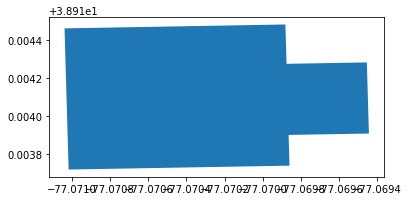

In [70]:
one_square = squares.iloc[1:2]
one_square.plot()

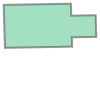

In [118]:
shape1 = one_square.geometry.values[0]
shape1

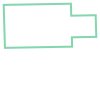

In [23]:
shape1_boundline = shape1.boundary
shape1_boundline

In [76]:
def generate_random(number, polygon):
    '''
    from https://gis.stackexchange.com/questions/207731/generating-random-coordinates-in-multipolygon-in-python
    modified to output a geopandas df
    '''
    points = []
    minx, miny, maxx, maxy = polygon.bounds
    while len(points) < number:
        pnt = Point(random.uniform(minx, maxx), random.uniform(miny, maxy))
        if polygon.contains(pnt):
            points.append(pnt)
            
    points_df = gpd.GeoDataFrame(pd.DataFrame(range(len(points)),columns=['pt_id']),
                            crs="EPSG:4326",
                            geometry=points)
    return points_df

In [77]:
points_df = generate_random(1000, shape1)

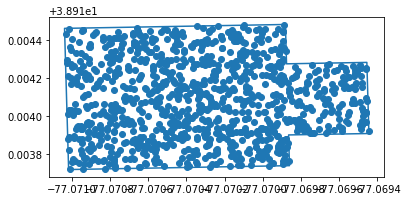

In [79]:
fig, ax = plt.subplots()
one_square.boundary.plot(ax=ax, color=None)
points_df.plot(ax=ax)

In [80]:
from sklearn.cluster import KMeans, DBSCAN

In [93]:
km4 = KMeans(n_clusters=4)

In [98]:
points_df.loc[:,'lat'] = points_df.loc[:,'geometry'].apply(lambda x: x.y)
points_df.loc[:,'lon'] = points_df.loc[:,'geometry'].apply(lambda x: x.x)
points_for_cluster = points_df.copy()
points_for_cluster.drop(labels=['geometry','pt_id'],axis=1,inplace=True)
points_for_cluster.head(3)

,lat,lon
0,38.913746,-77.069894
1,38.914021,-77.070079
2,38.914150,-77.069477


In [99]:
km4cls = km4.fit(points_for_cluster.values)

In [103]:
points_w_cl = points_df.assign(cluster=km4cls.labels_)
centers = km4cls.cluster_centers_

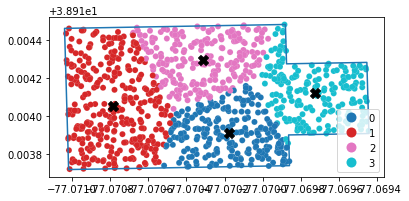

In [107]:
fig, ax = plt.subplots()
one_square.boundary.plot(ax=ax, color=None)
points_w_cl.plot(column='cluster', categorical=True, legend=True, linewidth=0.1, edgecolor='white', ax=ax)
centers_gseries = gpd.GeoSeries(map(Point, zip(centers[:,1], centers[:,0])))
centers_gseries.plot(ax=ax, alpha=1, marker='X', color='black', markersize=100, zorder=3)

In [117]:
centroid_coords = np.array([coords for coords in (zip(centers[:,1], centers[:,0]))])
centroid_coords

array([[-77.07017785,  38.91391096],
       [-77.07078342,  38.91405345],
       [-77.07031532,  38.91429471],
       [-77.06972624,  38.9141202 ]])

In [120]:
poly_shapes, pts, poly_to_pt_assignments  = voronoi_regions_from_coords(centroid_coords, shape1)

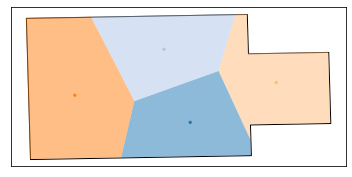

In [122]:
fig, ax = subplot_for_map()
plot_voronoi_polys_with_points_in_area(ax, shape1, poly_shapes, centroid_coords, poly_to_pt_assignments)
plt.show()

# wrap it all up

In [143]:
def split_poly_into_parts(poly, num_parts):
    '''
    '''
    points_df = generate_random(2500, poly)
    km = KMeans(n_clusters=num_parts)
    
    points_df.loc[:,'lat'] = points_df.loc[:,'geometry'].apply(lambda x: x.y)
    points_df.loc[:,'lon'] = points_df.loc[:,'geometry'].apply(lambda x: x.x)
    points_for_cluster = points_df.copy()
    points_for_cluster.drop(labels=['geometry','pt_id'],axis=1,inplace=True)
    
    kmcls = km.fit(points_for_cluster.values)
    
    points_w_cl = points_df.assign(cluster=kmcls.labels_)
    centers = kmcls.cluster_centers_
    
    centers_gseries = gpd.GeoSeries(map(Point, zip(centers[:,1], centers[:,0])))
    
    centroid_coords = np.array([coords for coords in (zip(centers[:,1], centers[:,0]))])
    
    poly_shapes, pts, poly_to_pt_assignments  = voronoi_regions_from_coords(centroid_coords, poly)
    
    poly_shapes_df = gpd.GeoDataFrame(pd.DataFrame(poly_to_pt_assignments,columns=['group']),
                            crs="EPSG:4326",
                            geometry=poly_shapes)
    
    return poly_shapes_df

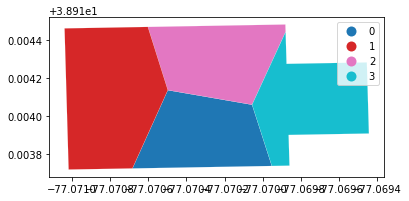

In [145]:
poly_shapes_df = split_poly_into_parts(shape1, 4)
fig, ax = plt.subplots()
poly_shapes_df.plot(column='group', categorical=True, legend=True, linewidth=0.1, edgecolor='white', ax=ax)

# try with another shape

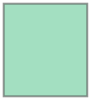

In [148]:
shape2 = squares.iloc[3].geometry
shape2

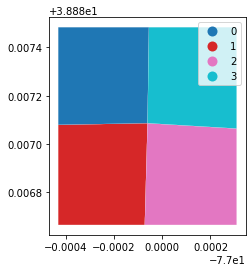

In [149]:
poly_shapes_df = split_poly_into_parts(shape2, 4)
fig, ax = plt.subplots()
poly_shapes_df.plot(column='group', categorical=True, legend=True, linewidth=0.1, edgecolor='white', ax=ax)

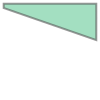

In [152]:
shape3 = squares.iloc[6].geometry
shape3

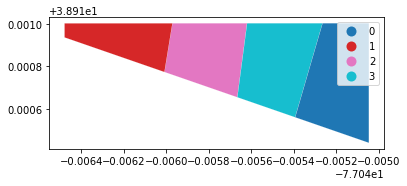

In [153]:
poly_shapes_df = split_poly_into_parts(shape3, 4)
fig, ax = plt.subplots()
poly_shapes_df.plot(column='group', categorical=True, legend=True, linewidth=0.1, edgecolor='white', ax=ax)

# if the block is big enough - Kmeans will split the triangle in another way

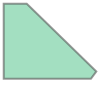

In [162]:
shape4 = squares[squares.loc[:,'SQUARE']=='2915'].geometry.values[0]
shape4

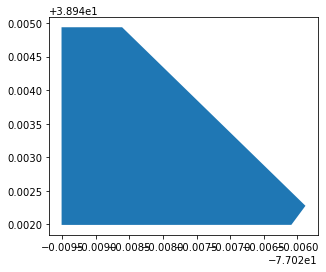

In [164]:
squares[squares.loc[:,'SQUARE']=='2915'].plot()

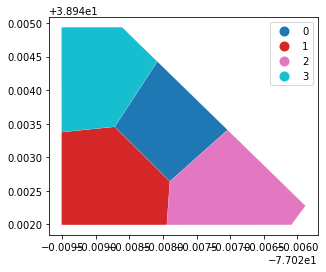

In [163]:
poly_shapes_df = split_poly_into_parts(shape4, 4)
fig, ax = plt.subplots()
poly_shapes_df.plot(column='group', categorical=True, legend=True, linewidth=0.1, edgecolor='white', ax=ax)

# what about using address/building points as the input of the cluster?